In [27]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import splitfolders
import cv2

In [28]:
# Define path variables
root_path = "C:/Users/ayahm/OneDrive/Desktop/PlantVillage"
output_path = "output"
model_path = "tomato_disease_cnn_model.h5"
img_height, img_width = 224, 224  # Increased from 200x200 for better feature extraction

In [29]:
# Get class names (folder names)
class_names = sorted([d for d in os.listdir(root_path) if os.path.isdir(os.path.join(root_path, d))])
print("Classes:", class_names)
num_classes = len(class_names)

Classes: ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


In [30]:
!pip install split_folders

In [31]:
# Split data into train, validation, and test sets
splitfolders.ratio(root_path, output=output_path, seed=1337, ratio=(0.7, 0.2, 0.1))

Copying files: 18160 files [00:20, 873.79 files/s]


In [42]:
# Data augmentation with lower overhead
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

In [44]:
# Only preprocess for validation and test sets
val_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)
test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)


In [45]:
# Batch size
batch_size = 64

# Data generators
train_generator = train_datagen.flow_from_directory(
    os.path.join(output_path, "train"),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(output_path, "val"),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(output_path, "test"),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Important for evaluation
)


Found 12707 images belonging to 10 classes.
Found 3628 images belonging to 10 classes.
Found 1825 images belonging to 10 classes.


In [46]:
# Try to enable mixed precision for faster GPU training
try:
    mixed_precision = tf.keras.mixed_precision.experimental
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_global_policy(policy)
    print('Mixed precision enabled')
except:
    print('Mixed precision not available')

Mixed precision not available


In [48]:
# Create MobileNetV2 base model (much lighter than ResNet50)
from tensorflow.keras.applications import MobileNetV2
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(img_height, img_width, 3),
    alpha=0.75  # Use smaller network (75% of filters)
)


5903360/5903360 [==============================] - 2s 0us/step


In [49]:
# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

In [50]:
# Create a lightweight model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu'),  # Reduced from 512
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [51]:
# Model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_0.75_224 (Funct  (None, 7, 7, 1280)       1382064   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization_27 (Bat  (None, 1280)             5120      
 chNormalization)                                                
                                                                 
 dense_9 (Dense)             (None, 128)               163968    
                                                                 
 dropout_18 (Dropout)        (None, 128)               0         
                                                      

In [52]:
# Calculate steps per epoch and validation steps
steps_per_epoch = train_generator.samples // batch_size
validation_steps = val_generator.samples // batch_size

# Compile model with Adam optimizer
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# Callbacks with early stopping to prevent unnecessary computation
callbacks = [
    keras.callbacks.ModelCheckpoint(
        model_path,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='max'
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=0.00001
    )
]


In [53]:
# Train model (Stage 1: only head layers)
print("Stage 1: Training only the head layers")
history_stage1 = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=10,  # Fewer epochs for faster training
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=callbacks
)

Stage 1: Training only the head layers
Epoch 1/10
198/198 [==============================] - ETA: 0s - loss: 0.6385 - accuracy: 0.7917
Epoch 1: val_accuracy improved from -inf to 0.88783, saving model to tomato_disease_cnn_model.h5
198/198 [==============================] - 278s 1s/step - loss: 0.6385 - accuracy: 0.7917 - val_loss: 0.3312 - val_accuracy: 0.8878 - lr: 0.0010
Epoch 2/10
198/198 [==============================] - ETA: 0s - loss: 0.3387 - accuracy: 0.8842
Epoch 2: val_accuracy improved from 0.88783 to 0.92048, saving model to tomato_disease_cnn_model.h5
198/198 [==============================] - 137s 693ms/step - loss: 0.3387 - accuracy: 0.8842 - val_loss: 0.2352 - val_accuracy: 0.9205 - lr: 0.0010
Epoch 3/10
198/198 [==============================] - ETA: 0s - loss: 0.2682 - accuracy: 0.9107
Epoch 3: val_accuracy did not improve from 0.92048
198/198 [==============================] - 133s 670ms/step - loss: 0.2682 - accuracy: 0.9107 - val_loss: 0.2521 - val_accuracy: 0.91

In [54]:
# Fine-tuning: Unfreeze some layers of the base model for fine-tuning
print("Stage 2: Fine-tuning MobileNetV2 layers")
# Unfreeze only the last 15 layers (instead of 30) for faster training
for layer in base_model.layers[-15:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

# Recompile with a lower learning rate
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),  # Lower learning rate for fine-tuning
    metrics=['accuracy']
)


Stage 2: Fine-tuning MobileNetV2 layers


In [55]:
# Train model (Stage 2: fine-tuning with fewer epochs)
history_stage2 = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=5,  # Fewer epochs
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=callbacks
)

Epoch 1/5
198/198 [==============================] - ETA: 0s - loss: 0.1693 - accuracy: 0.9429
Epoch 1: val_accuracy did not improve from 0.94085
198/198 [==============================] - 144s 708ms/step - loss: 0.1693 - accuracy: 0.9429 - val_loss: 0.4051 - val_accuracy: 0.8797 - lr: 1.0000e-04
Epoch 2/5
198/198 [==============================] - ETA: 0s - loss: 0.1399 - accuracy: 0.9526
Epoch 2: val_accuracy did not improve from 0.94085
198/198 [==============================] - 149s 750ms/step - loss: 0.1399 - accuracy: 0.9526 - val_loss: 0.6072 - val_accuracy: 0.8435 - lr: 1.0000e-04
Epoch 3/5
198/198 [==============================] - ETA: 0s - loss: 0.1126 - accuracy: 0.9608
Epoch 3: val_accuracy did not improve from 0.94085
198/198 [==============================] - 133s 671ms/step - loss: 0.1126 - accuracy: 0.9608 - val_loss: 0.4804 - val_accuracy: 0.8850 - lr: 1.0000e-04
Epoch 4/5
198/198 [==============================] - ETA: 0s - loss: 0.1122 - accuracy: 0.9605
Epoch 4: va

In [56]:
# Combine histories for plotting
def combine_histories(h1, h2):
    combined_history = {}
    for key in h1.history.keys():
        combined_history[key] = h1.history[key] + h2.history[key]
    return type('obj', (object,), {'history': combined_history})

history = combine_histories(history_stage1, history_stage2)

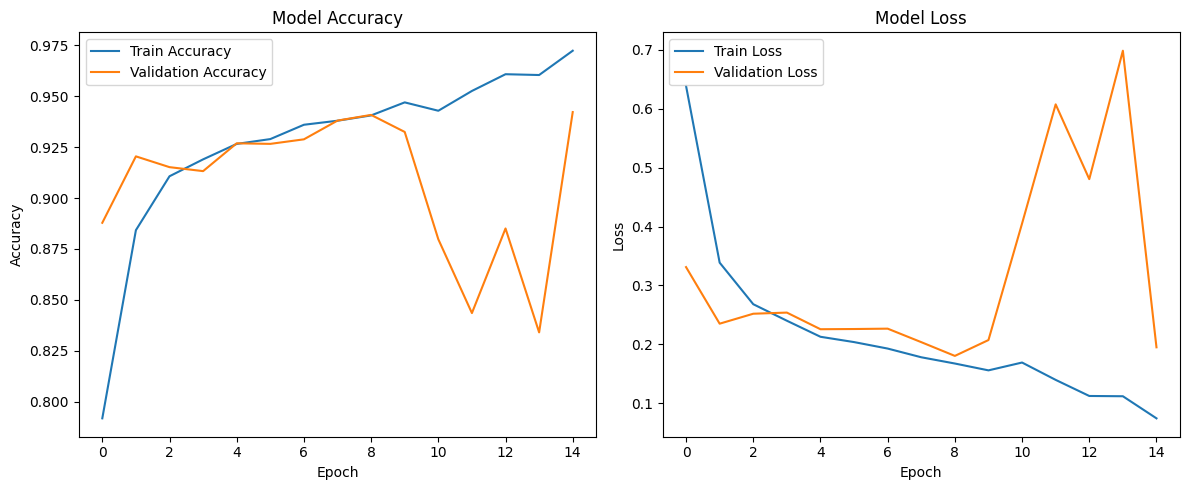

In [57]:
# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('mobilenet_training_history.png')
    plt.show()

plot_history(history)


In [58]:
# Evaluate model on test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

29/29 [==============================] - 18s 636ms/step - loss: 0.1656 - accuracy: 0.9468
Test accuracy: 0.9468
Test loss: 0.1656


In [59]:
# Predictions on test set
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

29/29 [==============================] - 5s 127ms/step


In [60]:
# Get class labels
class_labels = list(test_generator.class_indices.keys())

In [61]:
# Generate classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:")
print(report)

Classification Report:
                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.98      0.93      0.95       214
                        Tomato___Early_blight       0.89      0.76      0.82       100
                         Tomato___Late_blight       0.98      0.89      0.93       192
                           Tomato___Leaf_Mold       0.98      0.85      0.91        96
                  Tomato___Septoria_leaf_spot       0.79      1.00      0.88       178
Tomato___Spider_mites Two-spotted_spider_mite       0.97      0.93      0.95       168
                         Tomato___Target_Spot       0.88      0.96      0.92       142
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.99      0.99      0.99       537
                 Tomato___Tomato_mosaic_virus       0.95      1.00      0.97        38
                             Tomato___healthy       0.99      1.00      0.99       160

                  

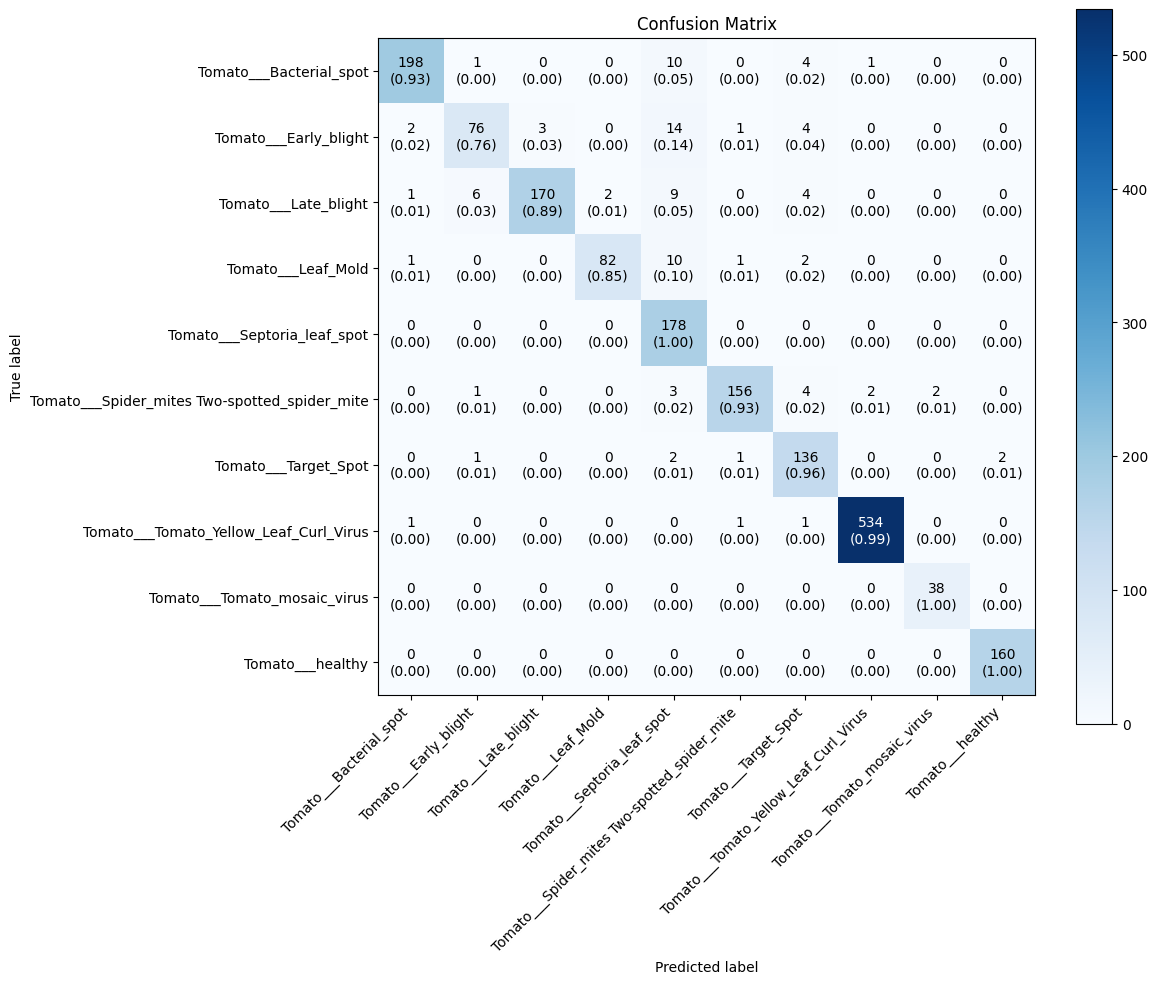

In [62]:
# Plot confusion matrix - simpler version
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha='right')
    plt.yticks(tick_marks, class_names)
    
    # Normalize confusion matrix for annotation
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, f"{cm[i, j]}\n({cm_normalized[i, j]:.2f})",
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('mobilenet_confusion_matrix.png')
    plt.show()

# Generate and plot confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plot_confusion_matrix(cm, class_labels)

In [64]:
# Function for inference on a single image
def predict_image(img_path, model):
    # Load and preprocess image
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError(f"Image not found at: {img_path}")
    
    img_resized = cv2.resize(img, (img_width, img_height))
    img_preprocessed = tf.keras.applications.mobilenet_v2.preprocess_input(img_resized.astype(np.float32))
    img_batch = np.expand_dims(img_preprocessed, axis=0)
    
    # Make prediction
    predictions = model.predict(img_batch)
    predicted_class = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class]
    
    # Get class name
    class_labels = list(train_generator.class_indices.keys())
    class_name = class_labels[predicted_class]
    
    # Display results
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
    plt.title(f'Prediction: {class_name}\nConfidence: {confidence:.2f}')
    plt.axis('off')
    plt.show()
    
    return class_name, confidence

In [68]:

def predict_image(img_path, model):
    import cv2
    import numpy as np
    import matplotlib.pyplot as plt
    import tensorflow as tf

    # Load and preprocess image
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError(f"Image not found at: {img_path}")
    
    img_resized = cv2.resize(img, (img_width, img_height))
    img_preprocessed = tf.keras.applications.mobilenet_v2.preprocess_input(img_resized.astype(np.float32))
    img_batch = np.expand_dims(img_preprocessed, axis=0)

    # Make prediction
    predictions = model.predict(img_batch)
    class_labels = list(train_generator.class_indices.keys())

    # Get top 3 predictions
    top_indices = predictions[0].argsort()[-3:][::-1]

    # Display image
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    # Display the top prediction as title
    top_label = class_labels[top_indices[0]]
    top_conf = predictions[0][top_indices[0]]
    plt.title(f"Top-1: {top_label} ({top_conf:.2f})")
    plt.show()

    # Print top 3 predictions
    print("\nTop 3 Predictions:")
    for i in top_indices:
        print(f"{class_labels[i]}: {predictions[0][i]:.2f}")

    return [(class_labels[i], predictions[0][i]) for i in top_indices]


1/1 [==============================] - 0s 29ms/step


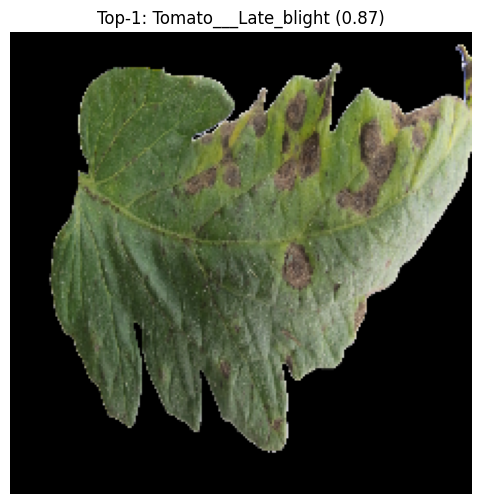


Top 3 Predictions:
Tomato___Late_blight: 0.87
Tomato___Early_blight: 0.08
Tomato___Target_Spot: 0.04


[('Tomato___Late_blight', 0.86703116),
 ('Tomato___Early_blight', 0.08436167),
 ('Tomato___Target_Spot', 0.043522436)]

In [93]:
predict_image("C:/Users/ayahm/Downloads/img_3478a (1).png", model)

In [94]:
# Save model (use SavedModel format for better compression)
model.save('tomato_disease_mobilenet.h5', save_format='h5')
print("MobileNet model saved successfully!")

MobileNet model saved successfully!


In [1]:
from tensorflow import keras
# Load your Keras model
model = keras.models.load_model('tomato_disease_mobilenet.h5')


In [2]:
import tensorflow as tf

# Create a converter
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# (Optional) Optimization for smaller size
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert the model
tflite_model = converter.convert()

# Save the TFLite model
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model converted and saved as model.tflite")

INFO:tensorflow:Assets written to: C:\Users\ayahm\AppData\Local\Temp\tmp3m0gr_s8\assets


INFO:tensorflow:Assets written to: C:\Users\ayahm\AppData\Local\Temp\tmp3m0gr_s8\assets


Model converted and saved as model.tflite
